# Diamond Price Prediction

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
data = pd.read_csv("Data/diamonds.csv")
data = data.drop(columns=["Unnamed: 0"])
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


A data frame with 53940 rows and 10 variables:
- price - price in US dollars (\$326--\$18,823)
- carat - weight of the diamond (0.2--5.01)
- cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color - diamond colour, from J (worst) to D (best)
- clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x - length in mm (0--10.74)
- y - width in mm (0--58.9)
- z - depth in mm (0--31.8)
- depth - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table - width of top of diamond relative to widest point (43--95)

In [6]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [4]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
data.duplicated().sum()

146

In [6]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()}")

carat: 273
cut: 5
color: 7
clarity: 8
depth: 184
table: 127
price: 11602
x: 554
y: 552
z: 375


In [7]:
for col in data.columns:
    if data[col].nunique()<10:
        print(f"{col}:\n{data[col].unique()}\n")

cut:
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']



color:
['E' 'I' 'J' 'H' 'F' 'G' 'D']

clarity:
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']



In [8]:
def num_plot(data):
    num_cols = data.select_dtypes(include=np.number).columns
    n = len(num_cols)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 3 * n))

    for i, col in enumerate(num_cols):
        sns.boxplot(x=data[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'Boxplot of {col}')

        sns.histplot(data[col], kde=True, bins=30, ax=axes[i, 1])
        axes[i, 1].set_title(f'Histogram of {col}')

    fig.suptitle("Boxplot and Histogram of Numerical Columns", fontsize=20, y=1)
    plt.tight_layout()
    plt.show()

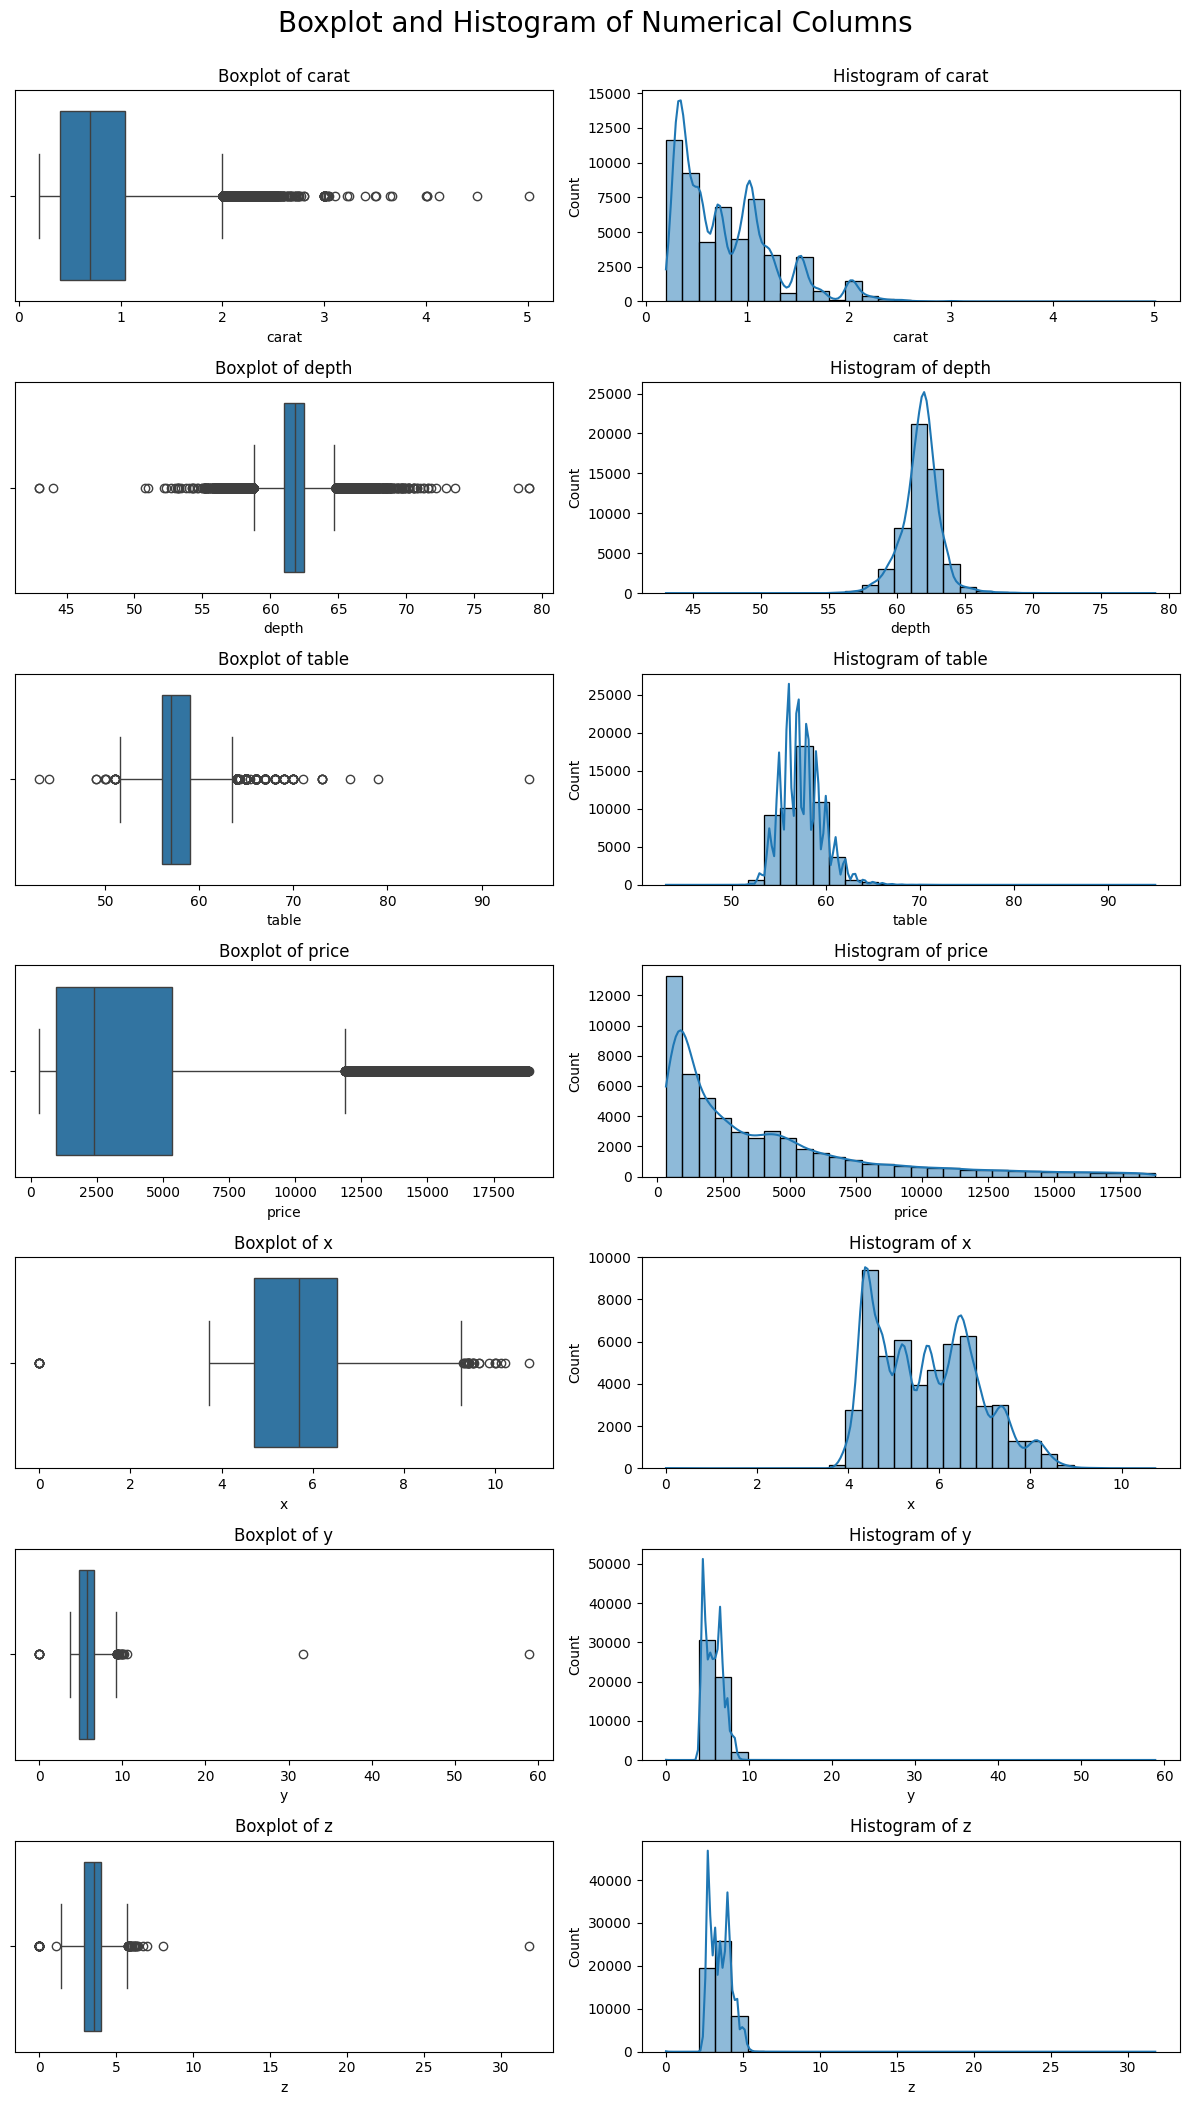

In [9]:
num_plot(data)

In [10]:
def cat_plot(data):
    cat_cols = data.select_dtypes(exclude=['number', 'datetime']).columns
    n = len(cat_cols)
    fig, axes = plt.subplots(nrows=round(n/2), ncols=2, figsize=(12, 2 * n))

    axes = axes.flatten()
    for i, col in enumerate(cat_cols):
        order = data[col].value_counts().index
        sns.countplot(data=data, x=col, ax=axes[i], order=order)
        axes[i].set_title(f'Barplot of {col}')

    fig.suptitle("Barplot of Numerical Columns", fontsize=20, y=1)
    plt.tight_layout()
    plt.show()

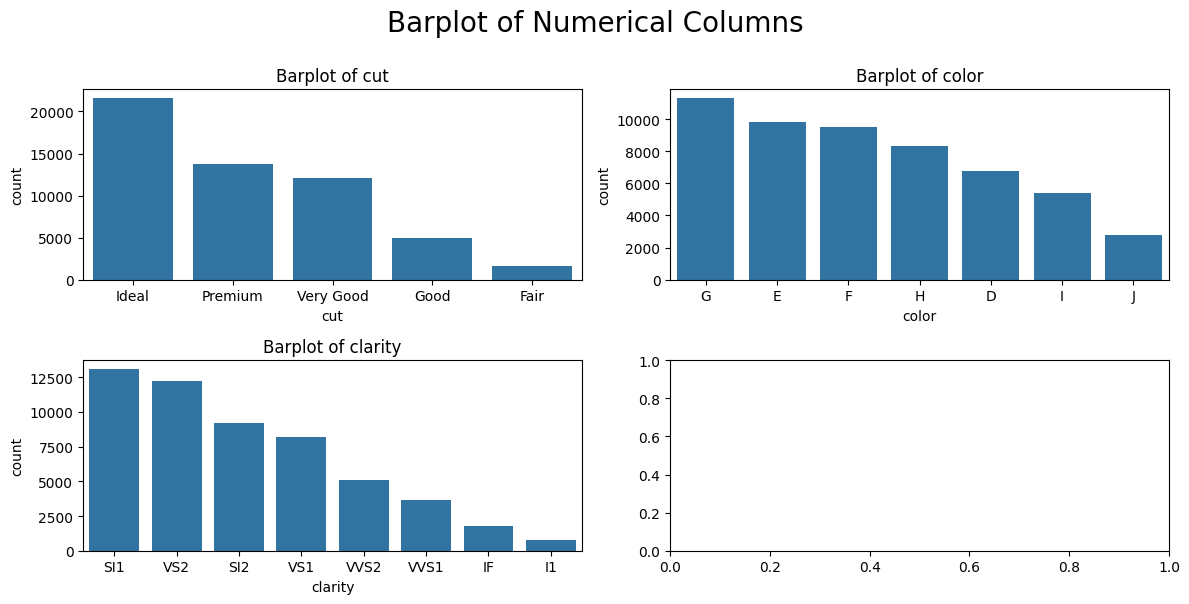

In [11]:
cat_plot(data)

## Data Preprocessing

In [12]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])

data[['cut', 'color', 'clarity']] = encoder.fit_transform(data[['cut', 'color', 'clarity']])
data[['cut', 'color', 'clarity']] = data[['cut', 'color', 'clarity']].astype(int)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In [13]:
X = data.drop('price', axis=1)
y = data['price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling is not needed since it gives the same MSE and R2

In [15]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.10f}")

Mean Squared Error: 280565.61
R² Score: 0.9823508263


In [ ]:
joblib.dump(model, "xgb_model.pkl")
joblib.dump(encoder, "ordinal_encoder.pkl")

['ordinal_encoder.pkl']